In [254]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Chap 11. 시계열 분석
## 11.1 시계열 분석 개요

- 시간에 흐름에 따라 일정한 간격으로 사건을 관찰하여 기록한 데이터를 바탕으로 미래의 관측값을 예측
- 일반적으로 추세(trend), 계절(season), 불규칙(irregular) 등으로 구성되며 이 성분들에 의해 변동된다고 가정
- 절차
1) 시계열 데이터 생성
    - 시계열 객체 생성 : 관측값 뿐만 아니라 시작 시점과 종료 시점, 주기 등의 정보 포함
2) 탐색적 분석을 통해 데이터 특성 이해
    - 시각화로 시계열 데이터의 변동 패턴 관찰
    - 성분분해를 통해 추세, 계절, 뷸규칙 성분으로 세분화
3) 미래 관측값에 대한 예측
    - 지수모델링(exponential modeling) : 관측값의 가중평균 이용
    - ARIMA(autoregressive integrated moving average) : 관측값과 오차간의 상관 이용

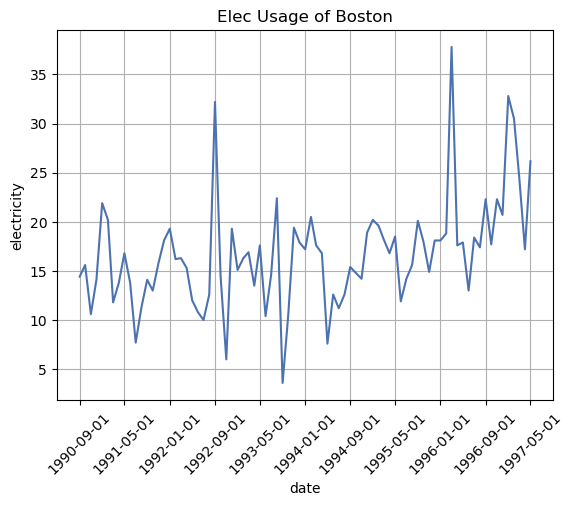

In [119]:
utility = pd.read_csv("../data/kwak/utility.txt", header=None, index_col=1).reset_index().drop(0, axis=1).set_index(1).iloc[:, 6]
utility.index = pd.to_datetime(utility.index, infer_datetime_format=True) # 자동 포맷 유추

p = so.Plot(x=utility.index, y=utility.values).add(so.Line()).label(x='date', y='electricity', title='Elec Usage of Boston')
fig, ax = plt.subplots()
p.on(ax).plot()

tick_interval = len(utility.index) // 10 if len(utility.index) > 10 else 1 # 간격 조절
selected_ticks = utility.index[::tick_interval]
ax.set_xticks(selected_ticks)
ax.set_xticklabels(selected_ticks.strftime('%Y-%m-%d'), rotation=45);
plt.grid()

## Datetime Module

In [160]:
import datetime
now = datetime.datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))
print(now + datetime.timedelta(days=1))
print(pd.to_datetime(now))
print(now.weekday())
print(utility.index.strftime('%y:%m:%d'))

2024-12-22 17:22:05
2024-12-23 17:22:05.114806
2024-12-22 17:22:05.114806
6
Index(['90:09:01', '90:10:01', '90:11:01', '90:12:01', '91:01:01', '91:02:01',
       '91:03:01', '91:04:01', '91:05:01', '91:06:01', '91:07:01', '91:08:01',
       '91:09:01', '91:10:01', '91:11:01', '91:12:01', '92:01:01', '92:02:01',
       '92:03:01', '92:04:01', '92:05:01', '92:06:01', '92:07:01', '92:08:01',
       '92:09:01', '92:10:01', '92:11:01', '92:12:01', '93:01:01', '93:02:01',
       '93:03:01', '93:04:01', '93:05:01', '93:06:01', '93:07:01', '93:08:01',
       '93:09:01', '93:10:01', '93:11:01', '93:12:01', '94:01:01', '94:02:01',
       '94:03:01', '94:04:01', '94:05:01', '94:06:01', '94:07:01', '94:08:01',
       '94:09:01', '94:10:01', '94:11:01', '94:12:01', '95:01:01', '95:02:01',
       '95:03:01', '95:04:01', '95:05:01', '95:06:01', '95:07:01', '95:08:01',
       '95:09:01', '95:10:01', '95:11:01', '95:12:01', '96:01:01', '96:02:01',
       '96:03:01', '96:04:01', '96:05:01', '96:06:01', 

In [134]:
utility['1990-09-01':'1990-12-30':3]

1
1990-09-01    14.4
1990-12-01    14.1
Name: 8, dtype: float64

In [255]:
utility = pd.read_csv("../data/kwak/utility.txt", header=None, index_col=1).reset_index().drop(0, axis=1).set_index(1)[[3,7]]
utility.index= pd.to_datetime(utility.index, infer_datetime_format=True)

utility.rename(columns={3:'temp', 7:'elec'}, inplace=True)

temp = utility.loc[utility.index.month == 12]
temp.groupby(temp.index.year).agg(['mean', 'std', 'sum'])

temp           elec         
      mean std sum   mean std  sum
1                                 
1990  37.0 NaN  37  408.0 NaN  408
1991  39.0 NaN  39  524.0 NaN  524
1992  36.0 NaN  36  561.0 NaN  561
1993  36.0 NaN  36  607.0 NaN  607
1994  35.0 NaN  35  606.0 NaN  606
1995  29.0 NaN  29  579.0 NaN  579
1996  39.0 NaN  39  600.0 NaN  600

## 11.2 시계열 데이터 분해
- 데이터를 변동요인에 따라 구성성분으로 분해하는 과정
- 일반적으로 전반적 상승 또는 하락 경향을 나타내는 추세 성분과 설명 안되는 오차인 불규칙 성분으로 구성
- 시계열 데이터에 주기가 존재하고 계절적 요인의 영향을 받아 변동한다면 계절 성분이 추가로 포함

### 비계절 데이터 분해
- 불규칙정 변동 요인을 제거 또는 완화하여 의미있는 추세패턴 파악
1) 평활법 (smoothing)
    - 단순이동평균 or 중심이동평균
    $$y'_t = (y_{t-m} + \dots + y_t + \dots + y_{t+m})/k,\quad k=(2m+1)\ 관측값의\ 갯수$$
    $$ 데이터\ 양쪽\ 끝 \frac{k-1}{2}개\ 관측값은\ 계산에서\ 제외$$
        * k 는 일반적으로 홀수 선택
        
### 계절 데이터 분해
- 추세 성분 : 시간의 흐름에 따른 수준(관측값의 크기)의 변화
- 계절 성분 : 단위 기간 내에서 순환주기의 영향
- 불규칙 성분 : 추세 성분과 계절 성분에 의해 설명되지 않는 영향
- 가법 모델 (additive model) : 추세가 있으나, 변동폭이 크게 변하지 않음 
$$y_t = T_t + S_t + I_t$$
    - T : 추세효과 기여분, S : 계절효과 기여분, L : 불규칙효과 기여분
- 승법모델 (multiplicative model) : 변동폭이 수준에 비례하여 증폭되거나 감소
$$y_t = T_t \times S_t \times I_t \rightarrow log(y_t)=log(T_t \times S_t \times I_t) = log(T_t) + log(S_t) + log(I_t)$$

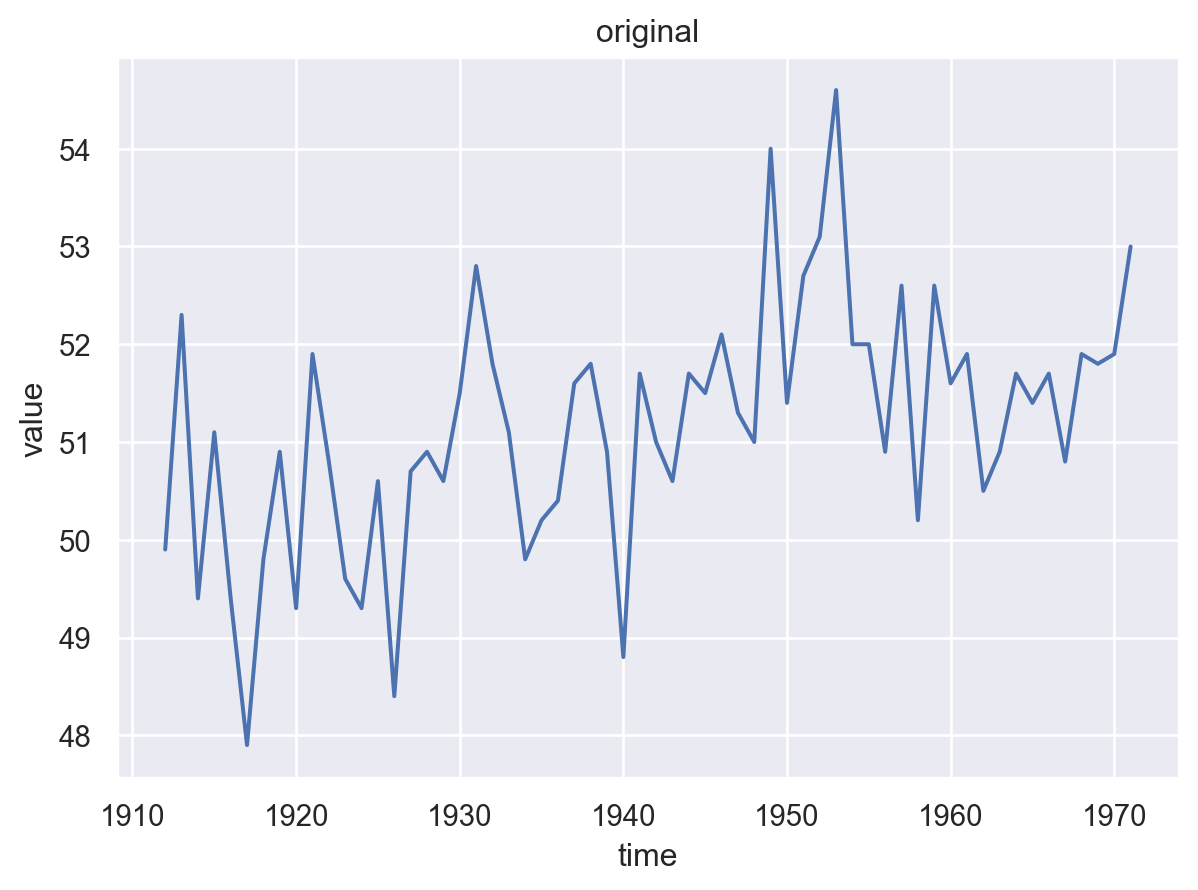

In [223]:
nhtemp = pd.read_csv("../data/kwak/nhtemp.csv").drop('rownames', axis=1).set_index('time')
so.Plot(data=nhtemp).add(so.Line(), x=nhtemp.index, y='value').label(title='original')

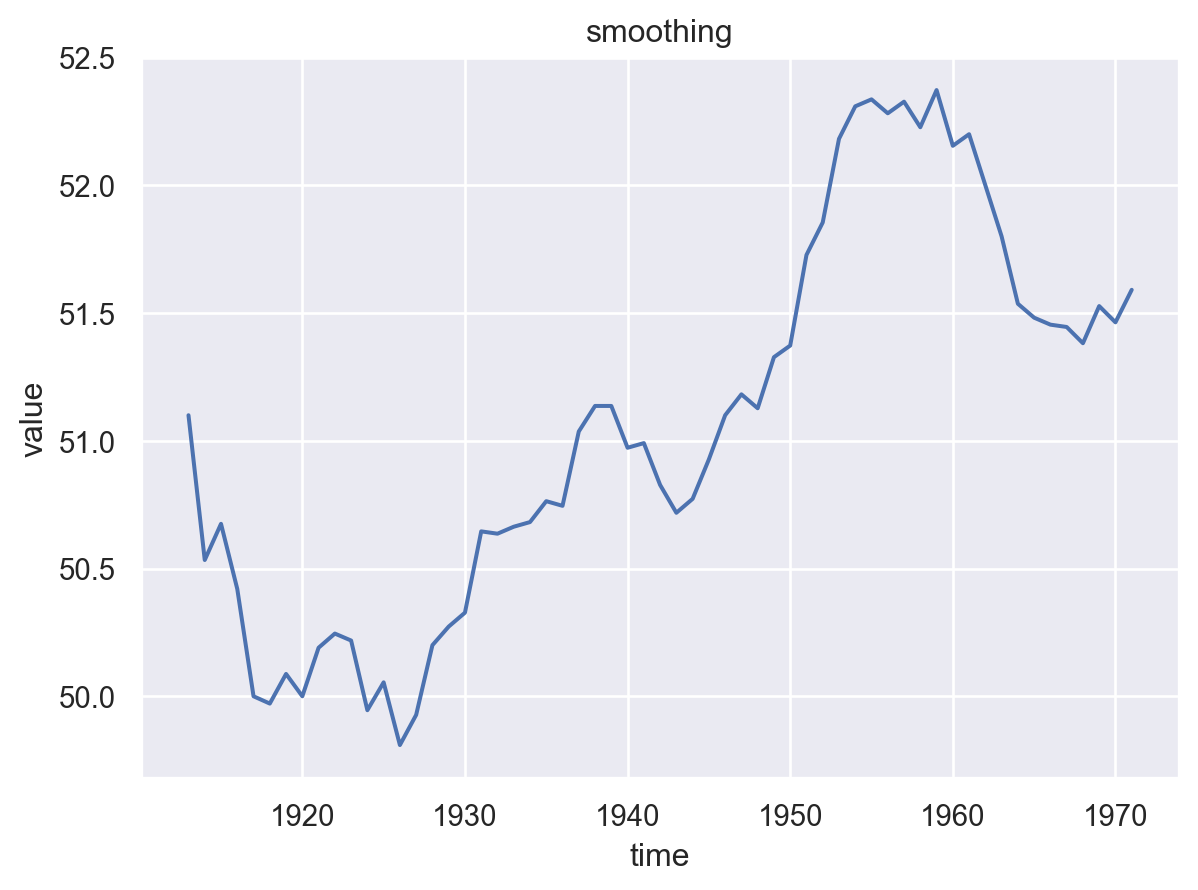

In [224]:
# smoothing
temp = nhtemp.rolling(window=11, min_periods=2, closed='right').mean()
so.Plot(data=temp).add(so.Line(), x=temp.index, y='value').label(title='smoothing')

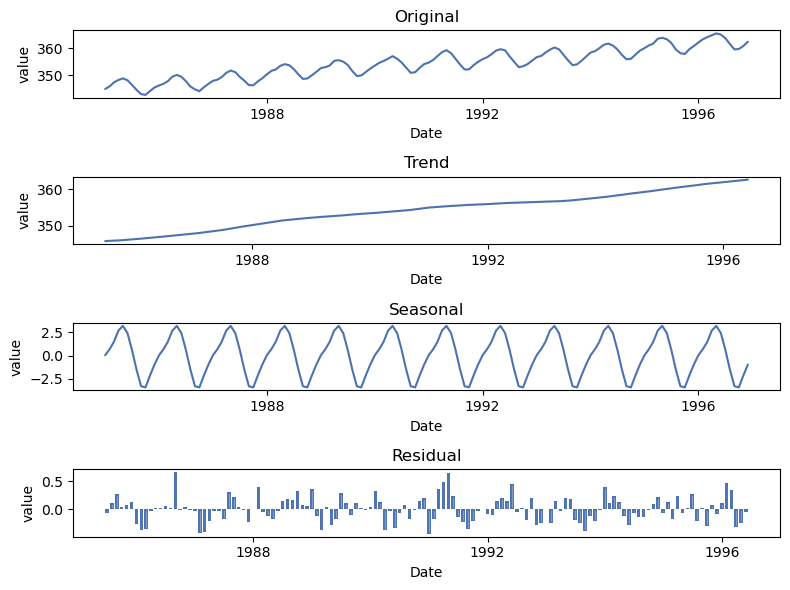

In [302]:
from statsmodels.tsa.seasonal import seasonal_decompose

co2 = pd.read_csv('../data/kwak/co2.csv').drop('rownames', axis=1)

co2['year'] = list(map(lambda x: str(math.trunc(float(x))), co2['time']))
co2['month'] = list(map(lambda x: str(int(float('0.' + str(x).split('.')[1])*12)+1), co2['time']))
co2['time'] = pd.to_datetime(co2['year'] + '-' + co2['month'], infer_datetime_format=True)
co2.set_index('time', inplace=True)
co2.drop(['year', 'month'], axis=1, inplace=True)
co2 = co2['1985-01-01':'1996-12-01']

decomp_result = seasonal_decompose(co2, period=12) # additive, multiplicative

# decompose result
fig, axes = plt.subplots(4,1, figsize=(8,6))

so.Plot(x=co2.index, y=co2['value']).add(so.Line()).label(x='Date', y='value', title='Original').on(axes[0]).plot()
so.Plot(x=co2.index, y=decomp_result.trend).add(so.Line()).label(x='Date', y='value', title='Trend').on(axes[1]).plot()
so.Plot(x=co2.index, y=decomp_result.seasonal).add(so.Line()).label(x='Date', y='value', title='Seasonal').on(axes[2]).plot()
so.Plot(x=co2.index, y=decomp_result.resid).add(so.Bar()).label(x='Date', y='value', title='Residual').on(axes[3]).plot()

plt.tight_layout()
plt.show()

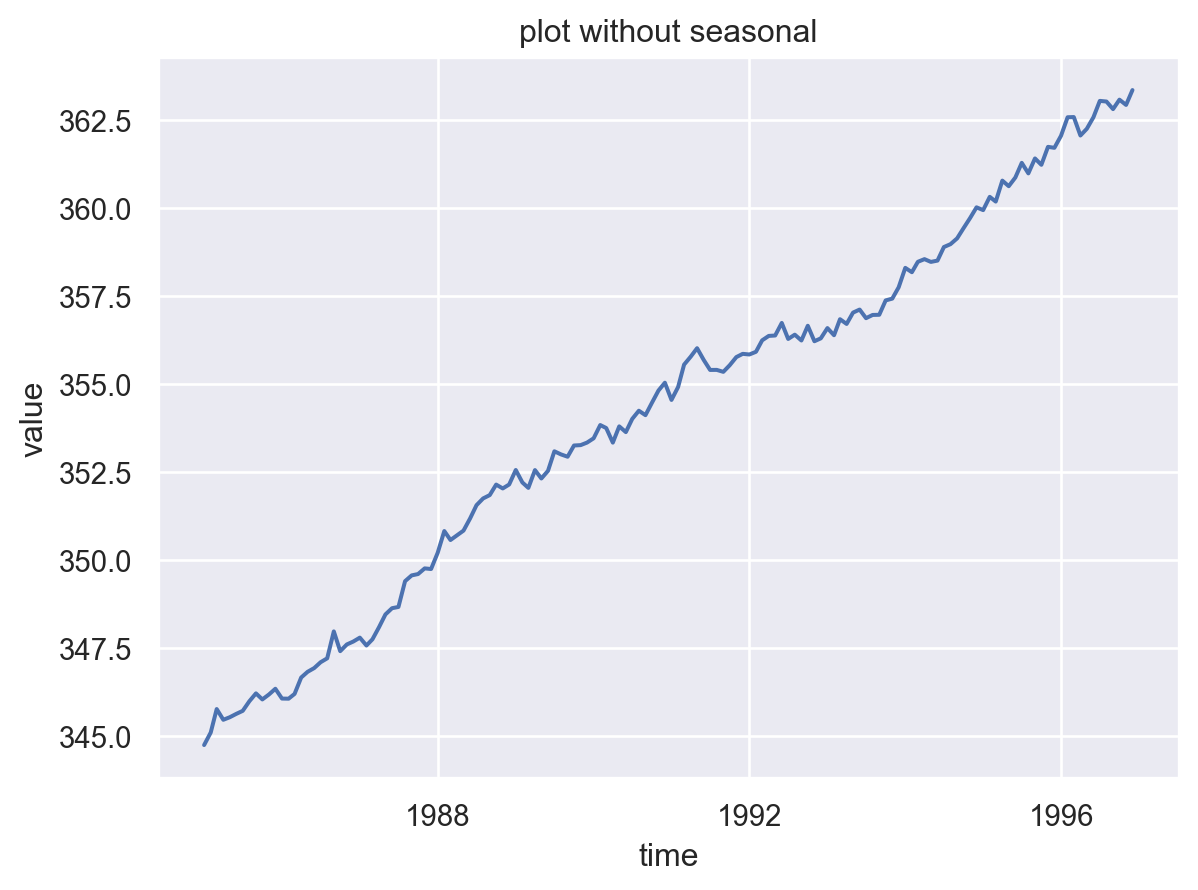

In [324]:
# plot without seasonal data 
so.Plot(x=co2.index, y=co2.value - decomp_result.seasonal).add(so.Line()).label(x='time', y='value', title='plot without seasonal').plot()

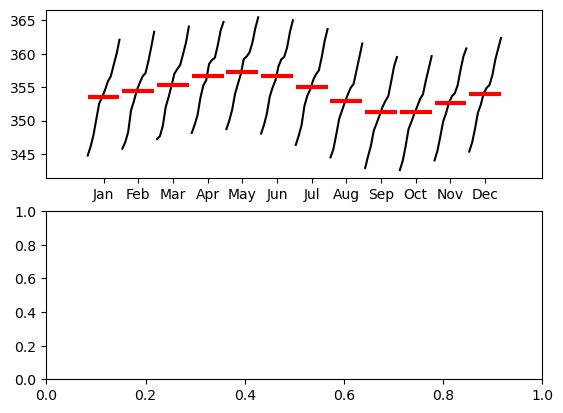

In [332]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

fig, axes = plt.subplots(2,1)

month_plot(co2, ax=axes[0]);
# quarter_plot(co2, ax=axes[1]);

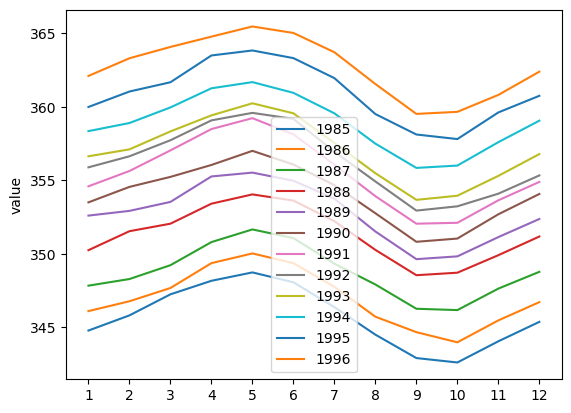

In [364]:
fig, ax = plt.subplots(1,1)
for year in co2.index.year.unique():
#     so.Plot(x=np.arange(1,len(co2.index.year.unique())+1), y=co2.loc[co2.index.year==year, 'value'], color=co2.index.year).add(so.Line()).on(ax).plot()#.legend
    sns.lineplot(x=np.arange(1,len(co2.index.year.unique())+1), y=co2.loc[co2.index.year==year, 'value'], label=year, ax=ax)
plt.xticks(np.arange(1,len(co2.index.year.unique())+1))
plt.show()

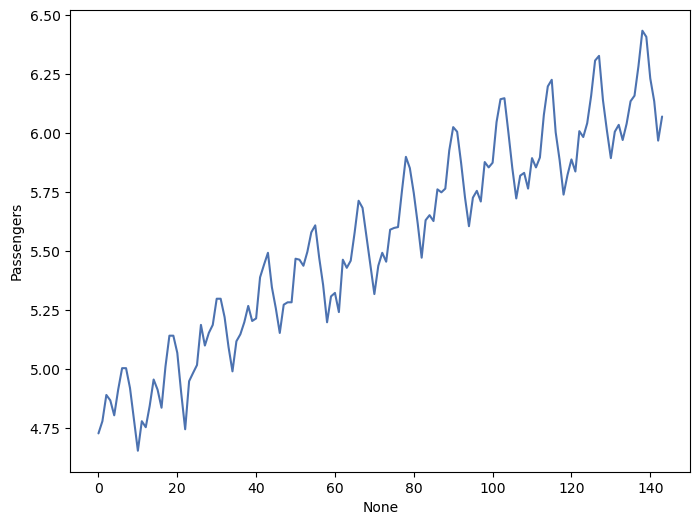

In [368]:
# multiplicative model
air = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/AirPassengers.csv", names=['Date', 'Passengers'])
air['Date'] = pd.to_datetime(air['Date'])
air['year'] = air['Date'].dt.year
air['month'] = air['Date'].dt.month

fig, ax = plt.subplots(figsize=(8,6))
so.Plot(x=air.index, y=np.log1p(air['Passengers'])).add(so.Line()).on(ax).plot(); #로그화 시켰으므로 additive rksmd
plt.show()

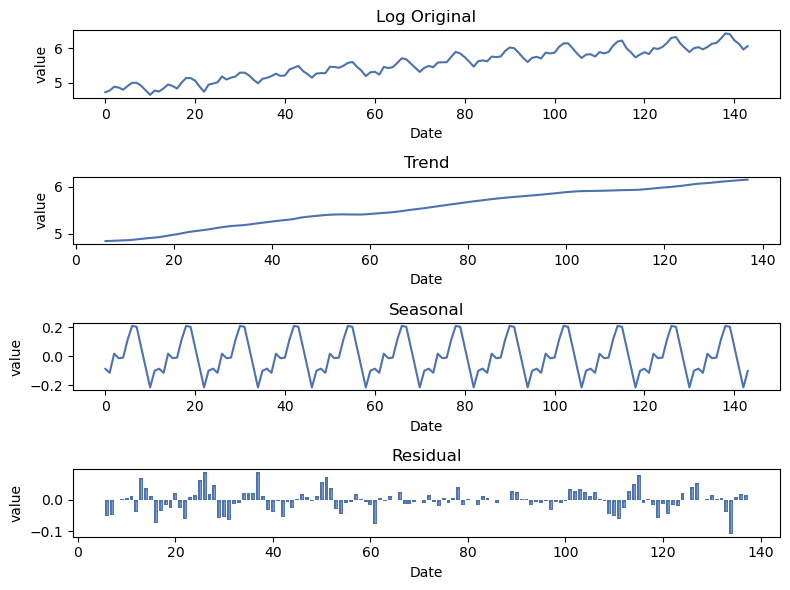

In [375]:
decomp_result = seasonal_decompose(np.log1p(air['Passengers']), period=12) # additive, multiplicative

# decompose result
fig, axes = plt.subplots(4,1, figsize=(8,6))

so.Plot(x=air.index, y=np.log1p(air['Passengers'])).add(so.Line()).label(x='Date', y='value', title='Log Original').on(axes[0]).plot()
so.Plot(x=air.index, y=decomp_result.trend).add(so.Line()).label(x='Date', y='value', title='Trend').on(axes[1]).plot()
so.Plot(x=air.index, y=decomp_result.seasonal).add(so.Line()).label(x='Date', y='value', title='Seasonal').on(axes[2]).plot()
so.Plot(x=air.index, y=decomp_result.resid).add(so.Bar()).label(x='Date', y='value', title='Residual').on(axes[3]).plot()

plt.tight_layout()
plt.show()

In [376]:
# log 변환한 데이터를 썼으므로 exp 필요
np.exp(decomp_result.seasonal)

0      0.918086
1      0.892241
2      1.018100
3      0.987033
4      0.991095
         ...   
139    1.225962
140    1.066670
141    0.927790
142    0.806681
143    0.904918
Name: seasonal, Length: 144, dtype: float64

## 11.3 지수예측모델
- 유형
1) 단순지수평활법 (simple exponential smoothing) : 수준 추정
    - 시계열 데이터가 전반적으로 일정 크기(불변 수준)를 갖고 있고, 추사나 계절적 요인이 없을 경우
    $$y_t = Level + I_t,\quad Level\ :\ 전반적\ 수준, \ \ I_t: t시점\ 불규칙\ 효과에\ 의한\ 변동분$$
    - 관측값의 가중평균을 이용하여 예측값 추정 : 관측값이 평균에 미치는 영향이 시간의 흐름에 따라 지수적으로 감소하는 방식으로 가중치 선택
    $$\hat{y}_{t+1} = \alpha y_t + \alpha (1-\alpha) y_{t-1} + \alpha (1-\alpha)^2 y_{t-2} + \dots$$
        - $\alpha$는 가중치에 대한 decay rate을 통제하여 가중치가 영향을 미치는 범위 결정, 1에 가까울 수록 최근 관측값에 더 큰 가중치 부여
        
2) 홀트지수평활법 (Holt exponential smoothing) : 수준, 기울기 추정
    - 수준과 추세(기울기)로 설명되는 시계열 데이터 예측
    - 수준, 불규칙 오차, 수세 성분에 의해 관측값 결정
    - t+1 시점에서의 예측값은 과거 모든 관측값의 가중평균
    $$y_t = Level+Slope\times t + I_t$$
        - 수준과 기울기에 대한 두 개의 가중치 필요
        - $\alpha, \beta$는 수준과 기울기에 대한 가중치의 영향력이 미치는 범위를 통제하며 큰 값일수록 최근의 관측값에 더 큰 가중치 부여
        
3) 홀트-윈터스지수평활법 (Holt-Winters exponential smoothing) : 수준, 기울기, 계절요인 추정
    - 수준, 추세(기울기), 계절로 설명되는 시계열 데이터를 예측
    - 수준, 불규칙 오차, 추세, 계절 성분에 의해 관측값이 결정
    - t+1 시점에서의 예측값은 과거 모든 관측값의 가중평균, $\alpha, \beta, \gamma$는 수준, 기울기, 계절에 대한 가중치 영향력이 미치는 범위 통제하며, 큰 값일수록 최근의 관측값에 더 큰 가중치 부여
    $$y_t = Level + Slope \times t+S_t+I_t,\qquad S_t:계절효과,\ I_t:불규칙 효과$$

In [461]:
from statsmodels.tsa.api import ExponentialSmoothing

# 눈에 띄는 추세가 없으며, 연도별 데이터라 계절성도 없음 => 단순지수평활법 고려
huron = pd.read_csv("../data/kwak/lakeHuron.csv").drop('rownames', axis=1)
huron['time'] = pd.to_datetime(huron['time'], format='%Y')
huron.set_index('time', inplace=True)

# alpha가 높음 : 예측 시 제일 최근 값이 우선
simple_exp_model = ExponentialSmoothing(huron, trend=None, seasonal=None)
simple_exp_fit = simple_exp_model.fit()

simple_exp_fit.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 580.3806513008535,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

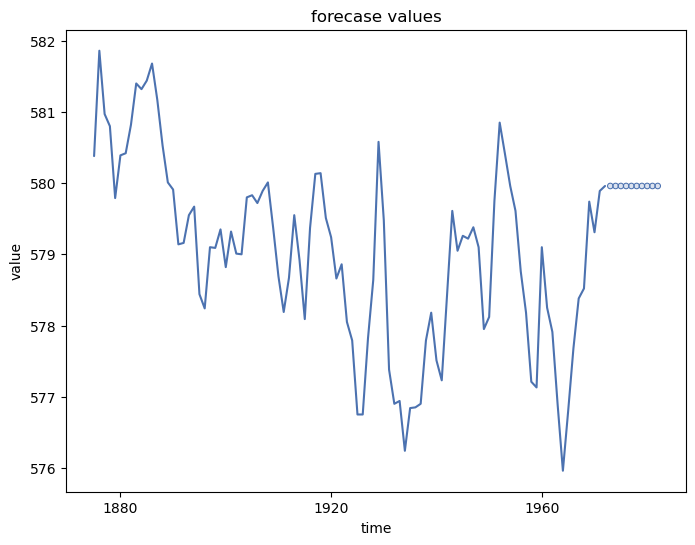

In [429]:
fig, axes = plt.subplots(1,1,figsize=(8,6))

preds = simple_exp_fit.forecast(steps=10)
so.Plot().add(so.Line(), x=huron.index, y=huron['value']).add(so.Dots(), x=preds.index, y=preds).on(axes).label(title='forecase values').plot();

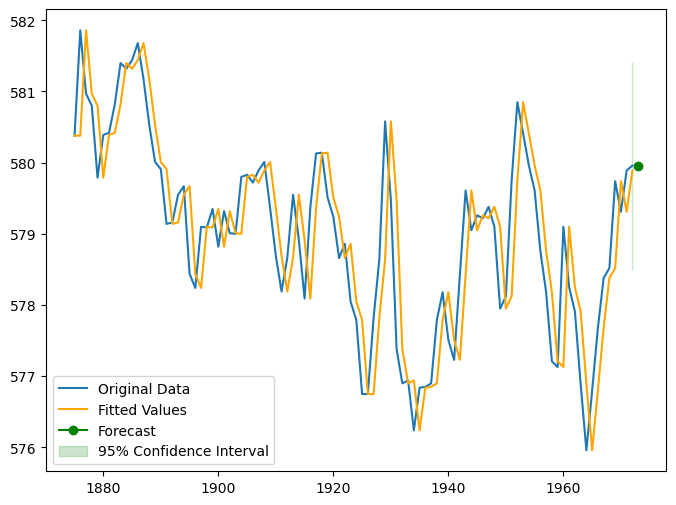

In [423]:
## 신뢰구간 
# 잔차와 분산 계산
residuals = huron['value'] - simple_exp_fit.fittedvalues
residual_variance = np.var(residuals, ddof=1)
std_error = np.sqrt(residual_variance)

# 신뢰구간 계산
z_value = stats.norm.ppf(0.975)  # 95% 신뢰구간
confidence_interval = z_value * std_error

# 신뢰구간 범위 생성
forecast_steps = 1
forecast = simple_exp_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=huron.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
lower_bound = forecast - confidence_interval
upper_bound = forecast + confidence_interval

# 신뢰구간 시각화
plt.figure(figsize=(8, 6))
plt.plot(huron, label='Original Data')
plt.plot(simple_exp_fit.fittedvalues, label='Fitted Values', color='orange')
plt.plot(forecast, label='Forecast', color='green', marker='o')
plt.fill_between(forecast_index, lower_bound, upper_bound, color='green', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.show()

In [425]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

## 모델 평가
# 정확도 : 학습데이터와 예측값 잔차분석
mae = mean_absolute_error(huron['value'], simple_exp_fit.fittedvalues)
rmse = np.sqrt(mean_squared_error(huron['value'], simple_exp_fit.fittedvalues))
mape = mean_absolute_percentage_error(huron['value'], simple_exp_fit.fittedvalues)
r2 = r2_score(huron['value'], simple_exp_fit.fittedvalues)

# Residual autocorrelation (lag-1)
acf1 = pd.Series(residuals).autocorr(lag=1)

print(f"MAE : {mae:.3f}, RMSE : {rmse:.3f}, MAPE : {mape:.3f}, R2 : {r2:.3f}, ACF1 : {acf1:.3f}")

MAE : 0.580, RMSE : 0.741, MAPE : 0.001, R2 : 0.680, ACF1 : 0.132


In [481]:
# 대세상승추세, 연도별 측정값이라 계절성 없음 => 홀트지수평활법 고려
elec = pd.read_csv("../data/kwak/elecsales.csv").drop('rownames', axis=1)
elec['time'] = pd.to_datetime(elec['time'], format='%Y')
elec.set_index('time', inplace=True)

# alpha, beta 낮음 : 예측 시 과거 값이 우선
holt_model = ExponentialSmoothing(elec, trend='add', seasonal=None)
holt_fit = holt_model.fit()

holt_fit.params

{'smoothing_level': 0.02856403570848591,
 'smoothing_trend': 0.028564035689827905,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 2173.0615315587756,
 'initial_trend': 74.18138446915802,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

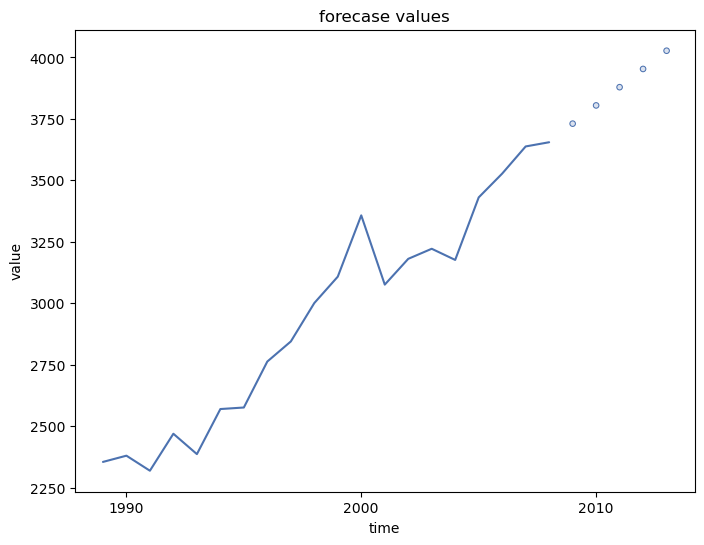

In [482]:
fig, axes = plt.subplots(1,1,figsize=(8,6))

preds = holt_fit.forecast(steps=5)
so.Plot().add(so.Line(), x=elec.index, y=elec['value']).add(so.Dots(), x=preds.index, y=preds).on(axes).label(title='forecase values').plot();

In [464]:
from statsmodels.tsa.api import ExponentialSmoothing

# 대세상승, 시간이 지날수록 계절적 폭 증가 
# => 승법 모델 필요, 홀트는 가법 모델 가정하므로 로그 함수 취해서 가법모델로 변형
lair = air.copy().drop(['year', 'month'], axis=1).set_index('Date')
lair['Passengers'] = np.log1p(lair['Passengers'])
holtwinter_model = ExponentialSmoothing(lair, trend='add', seasonal='add', seasonal_periods=12)
holtwinter_fit = holtwinter_model.fit()

holtwinter_fit.params

{'smoothing_level': 0.37628664494220276,
 'smoothing_trend': 7.580015948240548e-18,
 'smoothing_seasonal': 0.46024842951348705,
 'damping_trend': nan,
 'initial_level': 4.805156801708975,
 'initial_trend': 0.009737650268528335,
 'initial_seasons': array([-0.09298379, -0.03763949,  0.07785419,  0.0364609 , -0.02295907,
         0.07802577,  0.16313501,  0.14918105,  0.05178565, -0.09543089,
        -0.23692497, -0.09718416]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

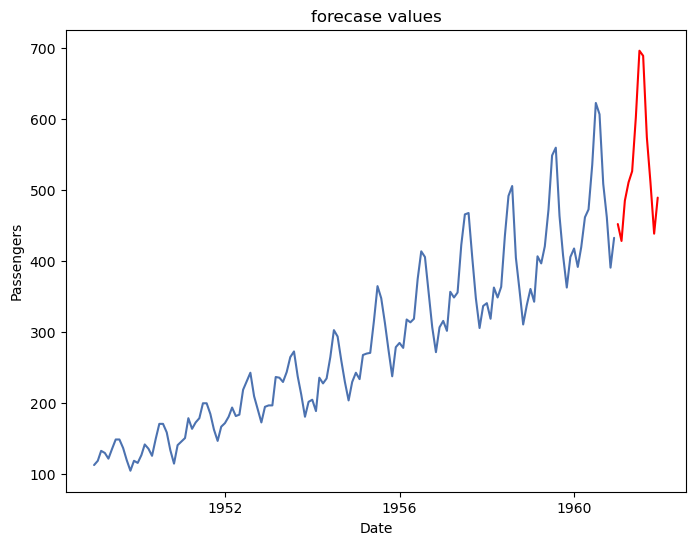

In [480]:
fig, axes = plt.subplots(1,1,figsize=(8,6))

preds = holtwinter_fit.forecast(steps=12)
so.Plot().add(so.Line(), x=lair.index, y=np.exp(lair['Passengers'])).add(so.Line(color='red'), x=preds.index, y=np.exp(preds)).on(axes).label(title='forecase values').plot();

## 11.4 ARIMA 예측모델
### 정상성과 자기상관
- 정상성(stationarity) : ARIMA 모델의 기본 가정, 시계열 데이터의 특성이 시간의 흐름에 따라 변하지 않는다
    - 장기적으로 예측가능한 패턴을 갖지 않으며, 시계열 그래프는 일정한 변동폭(일정한 분산)을 가지면서 대체로 수평에 가까운 패턴(일정한 평균)을 보임 => 평균과 분산이 안정화되어서 분석하기 쉬움을 의미
    - 추세와 계절 요인은 시간이 경과하며 관측값 영향 => 일반적으로 정상성 갖도록 전처리 수행
    - 불규칙 성분만으로 구성된 시계열은 정상적 : 불규칙 변동 제외 시 동일한 모습
- 자기상관(Autocorrelation) : 동일한 변수를 시점을 달리하여 관찰하였을 때 이 관측값들 사이의 상호관련된 정도
    - 정상 시계열은 어느 시계열 구간에서도 평균과 분산이 일정하며, 관측값 간의 공분산도 일정 => 자기상관이 시간에 따라 변화하지 않는다
    - 시차(lag)를 적용한 시계열 데이터를 이용하여 계산
- 자기상관함수(Autocorrelation function, ACF) : 시차에 따른 일련의 자기상관
    - 자기상관 $AC_k$는 원래 시계열 데이터($y_t$)와 k 시차가 고려된, $y_{t-k}$의 상관관계
    - 시차가 커질 수록 거리가 떨어져서 예측이 어려우므로 ACF가 0으로 가까워지게 됨
    - 시계열의 정상성 평가시 유용 : 정상 시계열의 ACF는 상대적 빨리 0으로 접근, 데이터가 관계가 없음 
- 편자기상관(Partial autocorrelation) : 시차가 다른 두 시계열 데이터 간의 순수한 상호연관성
    - 원래 시계열 데이터와 시차k 시계열 데이터 $y_{t-k}$간 순수한 상관관계
    - 두 시점 사이에 포함된 모든 시계열 데이터의 영향은 제거, 관측값 간의 좀더 명확한 상관성 확인
    - 편자기상관 함수(Partial Autocorrelation function, PACF) : 시차에 따른 일련의 편자기상관
- ACF, PACF 도표 => 시계열 데이터의 정상성 평가 & ARIMA 모델의 파라미터 및 모델의 적합도 평가
    - ACF, PACF 임계값 : $+/-\frac{1.96}{\sqrt{n}}$
- 정상 시계열로 변환
    - 변동폭이 일정하지 않음 : **로그 변환**을 통해 시간의 흐름에 따라 분산이 일정하게 유지
    - 추세나 계절적 요인 : **차분과정**으로 전 기간에 걸쳐 평균이 일정한 정상 시계열로 변환
        - 일반적으로 두번 이상의 차분은 불필요

1 : ADF 0.000, KPSS 0.100
2 : ADF 0.000, KPSS 0.100
3 : ADF 0.025, KPSS 0.100
4 : ADF 0.003, KPSS 0.100


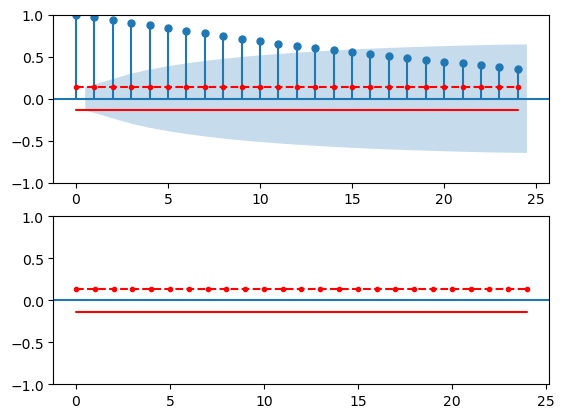

In [543]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss

# 추세 데이터 발견 => 차분 시도
goog = pd.read_csv('../data/kwak/goog200.csv', index_col='time').drop('rownames', axis=1)

# 적합한 차분 횟수 찾기 위해 ADF(H0 비정상 데이터), KPSS(H0 정상 데이터) 테스트 사용
for num in range(1, 5):
    diff_data = goog.diff(num).dropna()
    print(f"{num} : ADF {adfuller(diff_data)[1]:.3f}, KPSS {kpss(diff_data)[1]:.3f}")

diff_goog = goog.diff(1)

fig, axes = plt.subplots(2,1)
plot_acf(goog, ax=axes[0]);
so.Plot().add(so.Line(color='red', linestyle='--', marker='o', pointsize=3), x=np.arange(0,25,1), y=np.ones(25)*1.96/np.sqrt(len(goog))).add(so.Line(color='red'), x=np.arange(0,25,1), y=np.ones(25)*-1.96/np.sqrt(len(goog))).on(axes[0]).plot();
plot_acf(diff_goog, ax=axes[1]);
so.Plot().add(so.Line(color='red', linestyle='--', marker='o', pointsize=3), x=np.arange(0,25,1), y=np.ones(25)*1.96/np.sqrt(len(diff_goog))).add(so.Line(color='red'), x=np.arange(0,25,1), y=np.ones(25)*-1.96/np.sqrt(len(diff_goog))).on(axes[1]).plot();

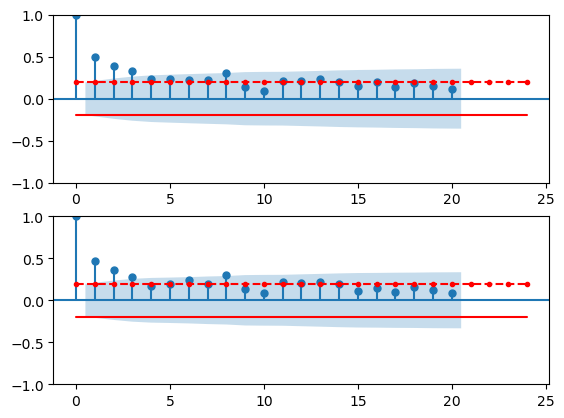

In [567]:
fig, axes = plt.subplots(2,1)
plot_acf(nile, ax=axes[0]);
so.Plot().add(so.Line(color='red', linestyle='--', marker='o', pointsize=3), x=np.arange(0,25,1), y=np.ones(25)*1.96/np.sqrt(len(nile))).add(so.Line(color='red'), x=np.arange(0,25,1), y=np.ones(25)*-1.96/np.sqrt(len(nile))).on(axes[0]).plot();
plot_acf(np.log1p(nile), ax=axes[1]);
so.Plot().add(so.Line(color='red', linestyle='--', marker='o', pointsize=3), x=np.arange(0,25,1), y=np.ones(25)*1.96/np.sqrt(len(nile))).add(so.Line(color='red'), x=np.arange(0,25,1), y=np.ones(25)*-1.96/np.sqrt(len(nile))).on(axes[1]).plot();

### ARIMA 예측모델
- AR (autoregressive) : 시계열 상의 과거 관측값을 이용하여 예측모델 생성
$$y_t = c+\phi_1y_{y-1} +\dots+\phi_py_{t-p}+\epsilon_y,\qquad \phi가중치,\ \epsilon오차$$
    - 예측하고자 하는 특정 변수의 과거 관측값의 선형결합으로 해당 변수 미래값 예측
    - 과거 p개의 관측값의 선형결합으로 해당 변수 미래값 예측 AR(p)
- MA (movingaverage) : 과거 예측오차 기반 예측모델 생성
$$ y_t = c+ \theta_1\epsilon_{t-1}+\dots+\theta_q\epsilon_{t-q},\qquad \theta가중치, \epsilon오차$$
    - 예측오차를 이용하여 미래의 값 예측
    - 과거 q개 예측오차의 선형결합으로 예측하는 모델 MA(q)
- ARMA(p,q)모델
$$y_t=c+\phi_1y_{t-1}+\dots+\phi_py_{t-p}+\theta_1\epsilon_{t-1}+\dots+\theta_q\epsilon_{t-q} + \epsilon_t$$
    - AR(p) & MA(q) 모델결합
    - 시계열의 각 값을 과거 p개 관측값과 q개 오차를 이용하여 예측
- ARIMA(p,d,q)모델
    - ARMA모델에 차분 추가
    - 시계열 데이터를 d회 차분하고 결과값은 과거 p개 관측값과 q개 오차에 의해 예측
    - 결과값은 비차분화 과정을 거쳐 최종 예측값으로 변환
- ARMIA 모델링
1) 시계열 데이터의 정상성 평가
    - 차분하며 정상성 확인 후, 차분 파라미터 d 확정
2) 예측모델 생성
    - ACF, PACF를 동시에 고려하여 ARIMA 모델의 p,q 결정
    - p : PACF가 0이 되기 직전 값, ACF는 점차 감소하며 0 접근
    - q : ACF가 0이 되기 직전 값, PACF는 점차 감소하며 0 접근
3) 예측모델 평가와 예측
    - 예측모델이 적절하다면 잔차가 평균 0의 정규분포 & 모든 가능한 시차에 대해 자기상관 0 (서로 독릷)

0.001175887950387114


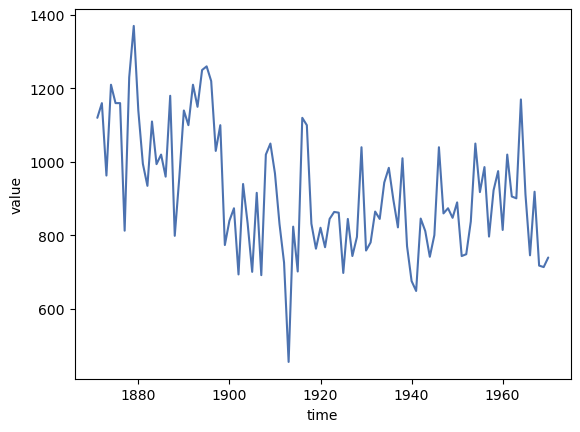

In [581]:
from statsmodels.tsa.stattools import adfuller
## 시계열 데이터의 정상성 평가
nile = pd.read_csv("../data/kwak/Nile.csv", index_col='time').drop('rownames', axis=1)

fig, axes = plt.subplots(1,1)
# 분산은 변하지 않고, 약간의 하락 추세 => 로그변환 불필요 & 정상성 확인필요
so.Plot().add(so.Line(), x=nile.index, y=nile['value']).on(axes).plot();

print(adfuller(nile)[1])

1 : ADF 0.000, KPSS 0.100
2 : ADF 0.000, KPSS 0.100
3 : ADF 0.005, KPSS 0.100
4 : ADF 0.000, KPSS 0.100


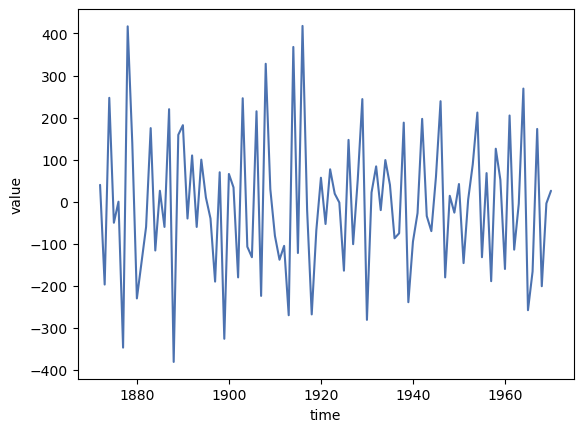

In [584]:
for num in range(1, 5):
    diff_data = nile.diff(num).dropna()
    print(f"{num} : ADF {adfuller(diff_data)[1]:.3f}, KPSS {kpss(diff_data)[1]:.3f}")

# 차분으로 추세 사라짐
dnile = nile.diff(1).dropna()  

fig, axes = plt.subplots(1,1)
so.Plot().add(so.Line(), x=dnile.index, y=dnile['value']).on(axes).plot();

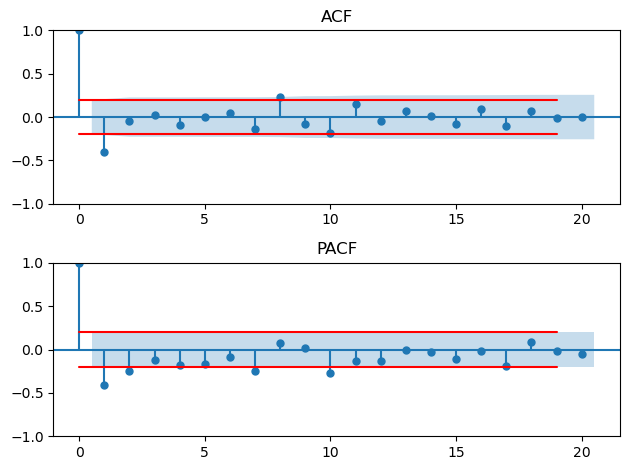

In [608]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
## 예측모델 생성

fig, axes = plt.subplots(2,1)

plot_acf(dnile, ax=axes[0]);
so.Plot().add(so.Line(color='red'), x=np.arange(0,20,1), y=np.ones(20)*1.96/np.sqrt(len(dnile))).add(so.Line(color='red'), x=np.arange(0,20,1), y=np.ones(20)*-1.96/np.sqrt(len(dnile))).label(title='ACF').on(axes[0]).plot();
plot_pacf(dnile, ax=axes[1]);
so.Plot().add(so.Line(color='red'), x=np.arange(0,20,1), y=np.ones(20)*1.96/np.sqrt(len(dnile))).add(so.Line(color='red'), x=np.arange(0,20,1), y=np.ones(20)*-1.96/np.sqrt(len(dnile))).label(title='PACF').on(axes[1]).plot();

plt.tight_layout()
# ACF => q = 1 / PACF => p = 2

In [625]:
from pmdarima import auto_arima

arima_model = auto_arima(nile, start_p=0, max_p=5, start_q=0, max_q=5, seasonal=False, trace=True, error_action='ignore', random_state=1)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1298.645, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1283.386, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1270.314, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1296.697, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1267.623, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1269.119, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1269.113, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1268.529, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1279.229, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1267.219, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1269.075, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1281.516, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1268.863, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -630.609
Date:                Sun, 29 Dec 2024   AIC                           1267.219
Time:                        18:47:15   BIC                           1275.004
Sample:                             0   HQIC                          1270.369
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2549      0.129      1.981      0.048       0.003       0.507
ma.L1         -0.8749      0.055    -16.019      0.000      -0.982      -0.768
sigma2      1.977e+04   2831.135      6.982      0.000    1.42e+04    2.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.74   Prob(JB):                         0.92
Heteroskedasticity (H):               0.60   Skew:                            -0.10
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

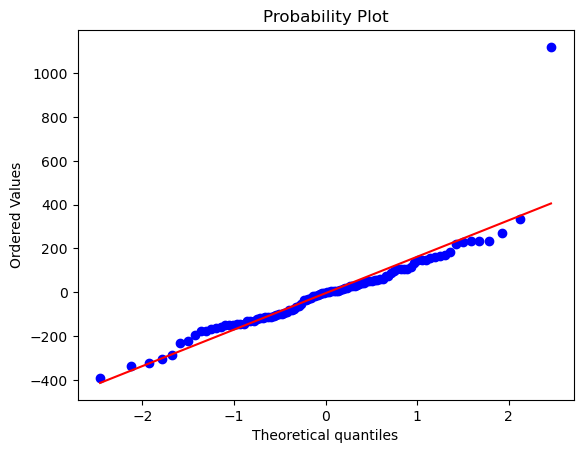

In [642]:
# 예측모델의 평가와 예측
## 위 Ljung-Box test : 0.05 기준, H0(잔차들의 상관관계 0) 기각 불가 => 자기상관 0과 다르다고 할 수 없음
## 이상치 하나 빼고 정규분포 라인에 잘 맞춰져 있음
stats.probplot(arima_model.resid(), dist=stats.norm, plot=plt);

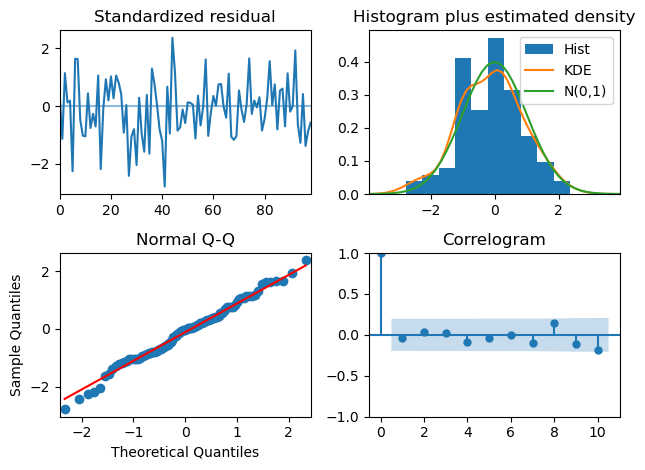

In [643]:
arima_model.plot_diagnostics()
plt.tight_layout()

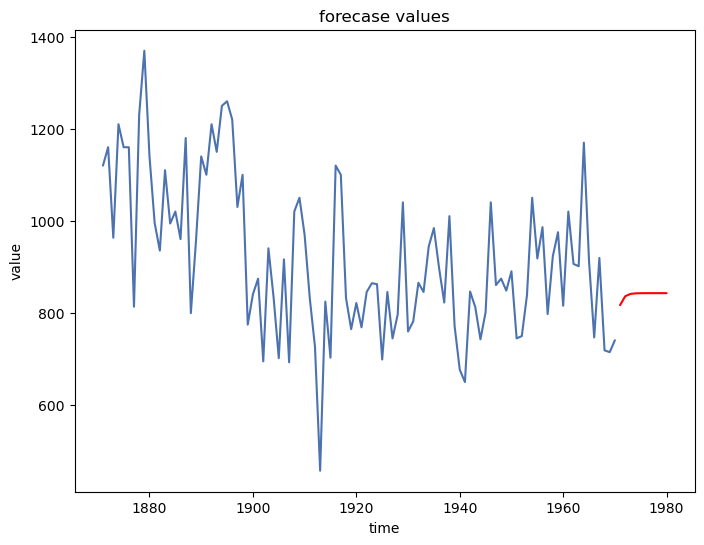

In [669]:
## 예측
fig, axes = plt.subplots(1,1,figsize=(8,6))

preds = arima_model.fit(nile).predict(10)
preds_index = list(map(lambda x : nile.index[-1] + x, np.arange(1, len(preds)+1, 1)))
so.Plot().add(so.Line(), x=nile.index, y=nile.iloc[:,0]).add(so.Line(color='red'), x=preds_index, y=preds).on(axes).label(title='forecase values').plot();

### 계절 성분과 모델 자동 선택

In [755]:
# 계절성 auto_arima

import math
from pmdarima import auto_arima

gas = pd.read_csv('../data/kwak/gas.csv').drop('rownames', axis=1)

gas['month'] = 0
gas['year'] = 0
for i in range(len(gas)):
    gas['year'][i] = int(gas['time'][i])
    gas['month'][i] = round((gas['time'][i] - int(gas['time'][i]))*12)+1
    gas['time'][i] = pd.to_datetime(str(gas['year'][i]) + '-' + str(gas['month'][i]), infer_datetime_format=True)

gas.drop(['year', 'month'], axis=1, inplace=True)
gas['time'] = pd.to_datetime(gas['time'], infer_datetime_format=True)
gas.set_index('time', inplace=True)

# 계절성 있을 경우 m parameter 사용
## (p,d,q)(a,b,c)[d]
## (a,b,d) : 비계절의 p, d, q
## [d] : 연간 관측값의 갯수
arima_model = auto_arima(gas, start_p=0, max_p=5, start_q=0, max_q=5, seasonal=True, m=12, trace=False, error_action='ignore', random_state=1)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  476
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -4190.415
Date:                            Mon, 30 Dec 2024   AIC                           8392.831
Time:                                    16:36:14   BIC                           8417.811
Sample:                                         0   HQIC                          8402.654
                                            - 476                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4637      0.042     11.029      0.000       0.381       0.546
ar.L2          0.1664      0.041      4.033      0.000       0.086       0.247
ma.L1         -0.9163      0.027    -34.348      0.000      -0.969      -0.864
ar.S.L12       0.9744      0.009    106.829      0.000       0.957       0.992
ma.S.L12      -0.5888      0.024    -24.396      0.000      -0.636      -0.542
sigma2      2.587e+06   8.19e+04     31.593      0.000    2.43e+06    2.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1338.96
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):             320.86   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

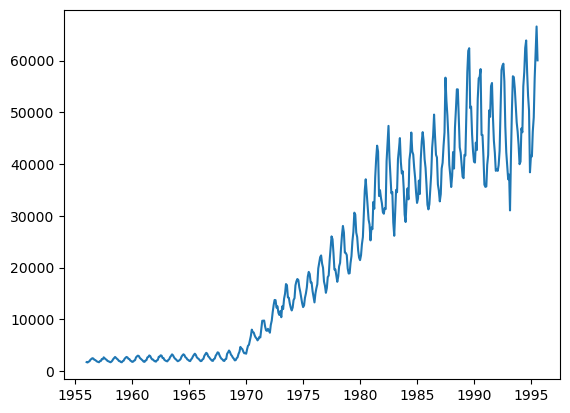

In [760]:
plt.plot(gas);

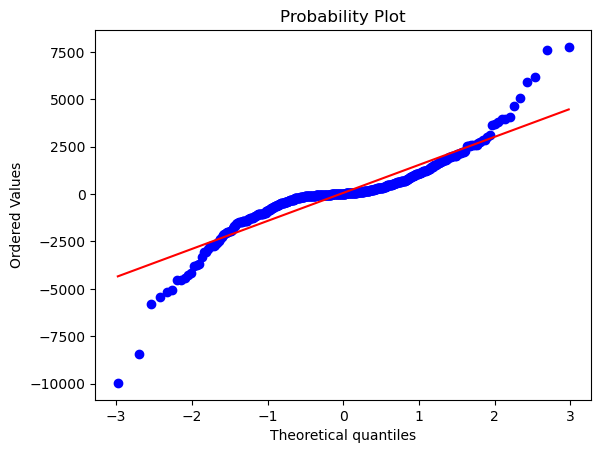

In [756]:
stats.probplot(arima_model.resid(), dist=stats.norm, plot=plt);

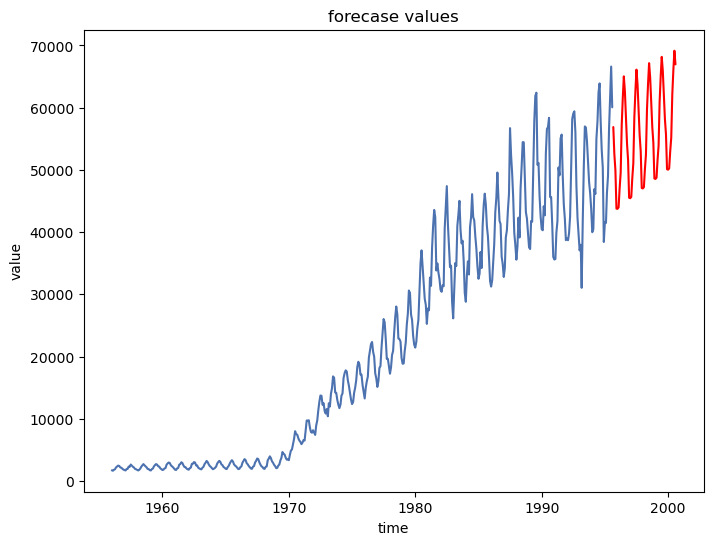

In [773]:
from dateutil.relativedelta import relativedelta

## 예측
fig, axes = plt.subplots(1,1,figsize=(8,6))

preds = arima_model.fit(gas).predict(5*12)
preds_index = list(map(lambda x : gas.index[-1] + relativedelta(months=x), np.arange(1, len(preds)+1, 1)))
so.Plot().add(so.Line(), x=gas.index, y=gas.iloc[:,0]).add(so.Line(color='red'), x=preds_index, y=preds).on(axes).label(title='forecase values').plot();

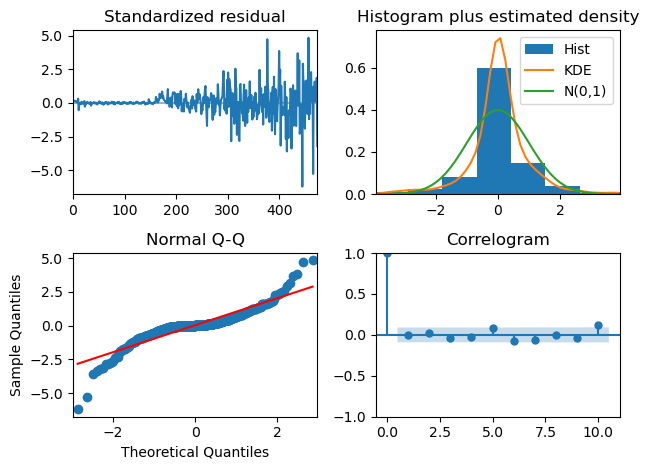

In [774]:
arima_model.plot_diagnostics()
plt.tight_layout()